In [40]:
## Import lib for extracting training set from pdfs
import extract
import importlib
importlib.reload(extract)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import optimize

In [43]:
# from file containing all segments of a particular type in the training set construct an array 
# storing sements of different CVs into separate elements
def string_list(s_term, s_str):
    result = []
    crnt_ptr = s_str.find(s_term) + len(s_term)
    scd_term_index=s_str.find(s_term, crnt_ptr)
    while (scd_term_index>=0):
        # count only significantly large segments 
        if (scd_term_index-crnt_ptr>9):
            result.append(s_term + ' ' + s_str[crnt_ptr:scd_term_index])
        crnt_ptr = scd_term_index + len(s_term)
        scd_term_index=s_str.find(s_term, crnt_ptr)
    return result

In [45]:
# Run through an array containing all segments on a particular topic from the whole training set
# Stem words, replace specific terms (like dates etc.) by a reserved token
# Costruct a dictionary from the words so processed 
import re
from nltk.stem.snowball import SnowballStemmer

def create_dictionary(topic_list):
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    result = dict()
    stemmer = SnowballStemmer('english')
    for string in topic_list:
        # split a certain CV part into words and filter blanks out
        a = re.split('[^0-9A-Za-z]', string)
        a=list(filter(lambda x: x!='', a))
        for i in range(len(a)):
            a[i] = a[i].casefold()
            if re.fullmatch(year_expr, a[i]):
                a[i] = '!year'
            elif re.fullmatch(month_expr, a[i]):
                a[i] = '!month'
            else:
                a[i] = stemmer.stem(a[i])
            if (a[i] in result):
                result[a[i]] += 1
            else:
                result[a[i]] = 1
                
    return result


# Same as above with string as an input
def create_dct_from_string(string):
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    result = dict()
    stemmer = SnowballStemmer('english')
    
    # split a certain CV part into words and filter blanks out
    a = re.split('[^0-9A-Za-z]', string)
    a=list(filter(lambda x: x!='', a))
    for i in range(len(a)):
        a[i] = a[i].casefold()
        if re.fullmatch(year_expr, a[i]):
            a[i] = '!year'
        elif re.fullmatch(month_expr, a[i]):
            a[i] = '!month'
        else:
            a[i] = stemmer.stem(a[i])
        if (a[i] in result):
            result[a[i]] += 1
        else:
            result[a[i]] = 1
                
    return result


In [47]:
# Functions for calculating term frequencies and corpus dictionary creation
def concat_dct(d1, d2):
    d3 = dict(d1)
    for key in d2.keys():
        if (key in d3):
            d3[key] += d2[key]
        else:
            d3[key] = d2[key]
    return d3

def sumDictValues(dctnr):
    N = 0
    for val in dctnr.values():
        N = N + val
    return N

def calc_probs(dctnr):
    prob_dctnr = dict()
    tot_size = sumDictValues(dctnr)
    for key in dctnr.keys():
        prob_dctnr[key] = dctnr[key]/tot_size
    return prob_dctnr

In [53]:
# Construct test data from string containing all segments on particular topic in the test set. 
#   Store data in an array consisting of ~100-word strings obtained by splitting the input data
#   Mark each string with appropriate category
#   Add method-specific column for convenience

def replace_with_space(matchobj):
    return " "

# For classification with ML method
def construct_marked_set(new_content):
    CRIT_LENGTH_LIMIT = 100
    result = np.zeros(4).reshape(1,4)
#    rep_pattern = re.compile(r"((Summary|Experience|Education)|[^A-Za-z0-9\s])")
    rep_pattern = re.compile(r"([^A-Za-z0-9\s])")
    category = 1
    for string in new_content:
        a = re.sub(rep_pattern, replace_with_space, string)
        cumulative_str = ''
        for substr in a.split('\n'):
            cumulative_str += substr + ' '
            if(len(cumulative_str) > CRIT_LENGTH_LIMIT):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
                cumulative_str = ''
        if(len(cumulative_str) > 2):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
        category += 1
    return result[1:]

# For classification with KL method
def construct_marked_set_KL(new_content):
    CRIT_LENGTH_LIMIT = 100
    result = np.zeros(4).reshape(1,4)
#    rep_pattern = re.compile(r"((Summary|Experience|Education)|[^A-Za-z0-9\s])")
    rep_pattern = re.compile(r"([^A-Za-z0-9\s])")
    category = 1
    for string in new_content:
        a = re.sub(rep_pattern, replace_with_space, string)
        cumulative_str = ''
        for substr in a.split('\n'):
            cumulative_str += substr + ' '
            if(len(cumulative_str) > CRIT_LENGTH_LIMIT):
                str_cnt_dct = create_dct_from_string(cumulative_str)
                str_prb_dict = calc_probs(str_cnt_dct)
                result = np.append(result, np.asarray([str_prb_dict, category, 0, m.inf]).reshape(1,4), axis=0)
                cumulative_str = ''
        if(len(cumulative_str) > 2):
                str_cnt_dct = create_dct_from_string(cumulative_str)
                str_prb_dict = calc_probs(str_cnt_dct)
                result = np.append(result, np.asarray([str_prb_dict, category, 0, m.inf]).reshape(1,4), axis=0)
        category += 1
    return result[1:]

In [55]:
# precision, recall, F1-score
def quality_assessment(a, b, ctgr):
    b_correct = ((a.astype(int) == b.astype(int)) * a.astype(int)==ctgr).sum()
    b_attempts = ((b.astype(int) == ctgr)).sum()
    a_total = ((a.astype(int) == ctgr)).sum()
    if b_attempts == 0:
        return 0, 0, 0
    prec = b_correct/b_attempts
    rcll = b_correct/a_total
    f_one = 2*prec*rcll/(prec+rcll)
#    print ('precision = %f' %prec)
#    print ('recall =', rcll)
#    print ('F1-score =', f_one)
    return prec, rcll, f_one

In [18]:
# Smoothing functions

def jelin_merc_smoothing(segm_dict, corpus_dict, lmbd):
    result_dct = dict()
    prb_dict = calc_probs(segm_dict)
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = (1-lmbd)*prb_dict[key] + lmbd*corpus_dict[key]
        else:
            result_dct[key] = lmbd*corpus_dict[key]
    return result_dct

def dirichlet_smoothing(segm_dict, corpus_dict, mu):
    result_dct = dict()
    #d = len(segm_dict.keys())
    d = sumDictValues(segm_dict)
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = segm_dict[key]/(d+mu) + mu/(d+mu)*corpus_dict[key]
        else:
            result_dct[key] = mu/(d+mu)*corpus_dict[key]
    return result_dct

In [223]:
# Classification functions. Take pre-arranged test array, make predictions

import math as m
from nltk.stem.snowball import SnowballStemmer
def calculate_ML(string, dct, corp_dct, prb_segment):
    stemmer = SnowballStemmer('english')
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    num = 1.0
    den = 1.0
    result = .0
    for word in string.split():
        wrd = word.casefold()
        if re.fullmatch(year_expr, wrd):
            wrd = '!year'
        elif re.fullmatch(month_expr, wrd):
            wrd = '!month'
        else:
             wrd = stemmer.stem(wrd)
        if wrd in dct:                  # and wrd in corp_dct:
            num *= dct[wrd]
            den *= corp_dct[wrd]
            result += m.log2(prb_segment*num/den)
        else:
            result += m.log2(1e-300)
    return result

def calculate_KL_risk(query_model, doc_model):
    result = 0
    for key in query_model.keys():
        log_ = 0
        if key in doc_model:
            log_ = m.log2(query_model[key]/doc_model[key])
        else:
            log_ = m.log2(1e+300)
        result += query_model[key]*log_
    return result

    
def test_algorithm(test_set, dictionaries, corpus_dict, smoothing=False, smoothing_method=None, smoothing_param=1):
    local_test_set = test_set.copy()
    #likelihoods = np.zeros(len(dictionaries))
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        prb_segment = sumDictValues(a_dict) / sumDictValues(corpus_dict)  # proportion of a segment in the corpus (according to ML formula)
#         print('Segment ' + repr(i+1) + ' portion in the dictionary ' + repr(prb_segment))
        if (smoothing == True):
            prb_dict = smoothing_method(a_dict, prb_corpus, smoothing_param)
        else:
            prb_dict = calc_probs(a_dict)
        for line in local_test_set:
            likelihood = calculate_ML(line[0], prb_dict, prb_corpus, prb_segment)
            if likelihood > np.float(line[3]):
                line[3] = likelihood
                line[2] = i+1
        i+=1
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score, local_test_set

def test_algorithm_w_KL(test_set_KL, dictionaries, corpus_dict, smoothing=False, smoothing_method=None, smoothing_param=1):
    local_test_set = test_set_KL.copy()
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        if (smoothing == True):
            prb_dict = smoothing_method(a_dict, prb_corpus, smoothing_param)
        else:
            prb_dict = calc_probs(a_dict)
        for line in local_test_set:
            risk = calculate_KL_risk(line[0], prb_dict)
            if risk < np.float(abs(line[3])):
                line[3] = risk
                line[2] = i+1
        i+=1
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score, local_test_set



In [41]:
#  Extract training set from PDFs
train_indicies = extract.extract_words()

In [42]:
# Read training files as one string
smr_content = open('sum_train.txt', 'r').read()
xprnc_content = open('exp_train.txt', 'r').read()
edct_content = open('edu_train.txt', 'r').read()

In [44]:
# Put segment from each CV into separate string in an array
sum_list = string_list("Summary", smr_content)
xprnc_list = string_list("Experience", xprnc_content)
edctn_list = string_list("Education", edct_content)

In [46]:
# Extract vocabulary specific for a segment
sum_dct = create_dictionary(sum_list)
xprnc_dct = create_dictionary(xprnc_list)
edctn_dct = create_dictionary(edctn_list)

In [50]:
# Uniting into corpus dictionary
new_dict = concat_dct(xprnc_dct, edctn_dct)
whole_dict = concat_dct(new_dict, sum_dct)

In [51]:
# Calculating term probabilities
sum_prb = calc_probs(sum_dct)
xprnc_prb = calc_probs(xprnc_dct)
edctn_prb = calc_probs(edctn_dct)
whole_dict_prb = calc_probs(whole_dict)

In [52]:
# Test data generation
smr_test_content = open('sum_test.txt', 'r').read()
exp_test_content = open('exp_test.txt', 'r').read()
edu_test_content = open('edu_test.txt', 'r').read()

In [132]:
# construct test data sets from the same data for verification of different methods
test_set = construct_marked_set([smr_test_content, edu_test_content, exp_test_content])
test_set_KL = construct_marked_set_KL([smr_test_content, edu_test_content, exp_test_content])

Comparison of classification results of ML and KL methods

In [157]:
f1_score, result_test_set_ML = test_algorithm(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)
print(f1_score)

0.726206887497


In [238]:
f1_score, result_test_set_KL = test_algorithm_w_KL(test_set_KL, [sum_dct, edctn_dct, xprnc_dct], whole_dict)
print(f1_score)

0.731116584565


In [243]:
(result_test_set_KL[:,2]==3).sum()

129

In [181]:
print(confusion_matrix(result_test_set_ML[:,1], result_test_set_ML[:,2]))

[[15  2 27]
 [ 0 30  6]
 [ 3  2 98]]


# Probability smoothing

In [192]:
def analyze_lmbd(test_set, dictionaries, corpus_dict, method='ML'):
    lmbd_arr = np.linspace(0,1,10)
    lmbd_arr[0] = 1e-10
    f_score_arr = np.zeros(lmbd_arr.size)
    for i in range(len(lmbd_arr)):
        if method == 'ML':
            f_score_arr[i], result_test_set = test_algorithm(test_set, dictionaries, corpus_dict, smoothing=True, smoothing_method=jelin_merc_smoothing, smoothing_param=lmbd_arr[i])
        else:
            f_score_arr[i], result_test_set = test_algorithm_w_KL(test_set, dictionaries, corpus_dict, smoothing=True, smoothing_method=jelin_merc_smoothing, smoothing_param=lmbd_arr[i])        
#     print('F1-score array: {}'.format(f_score_arr))
    print('Max F-score={} at lambda = {}'.format(np.max(f_score_arr), lmbd_arr[np.argmax(f_score_arr)]))
    return lmbd_arr, f_score_arr

In [205]:
classification_meth = 'ML'
if classification_meth == 'ML':
    test_set_smth = construct_marked_set([smr_test_content, edu_test_content, exp_test_content])
else:
    test_set_smth = construct_marked_set_KL([smr_test_content, edu_test_content, exp_test_content])

Max F-score=0.7656866545968727 at lambda = 0.6666666666666666


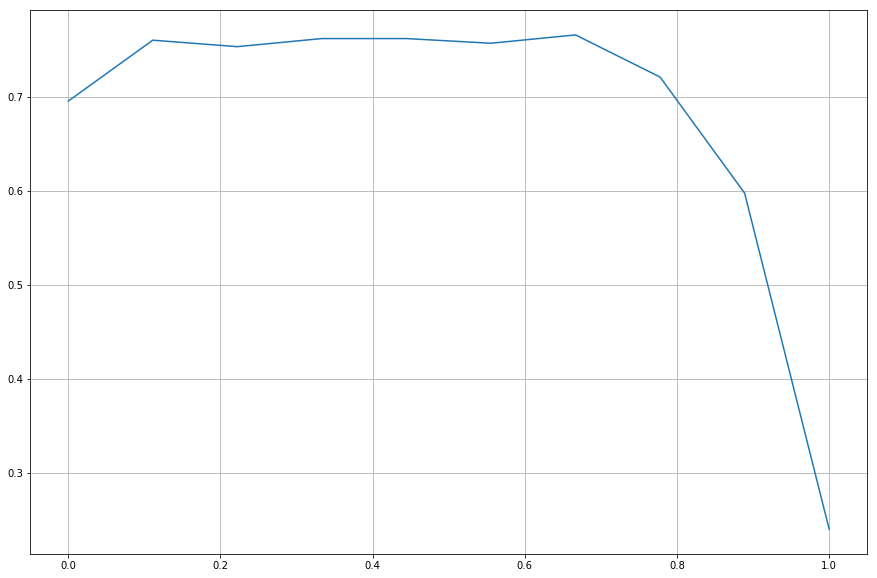

In [206]:
lambdas, f_scores = analyze_lmbd(test_set_smth, [sum_dct, edctn_dct, xprnc_dct], whole_dict, classification_meth)

fig = plt.figure(figsize=[15,10])
plt.plot(lambdas, f_scores)
plt.grid()
plt.show()

In [203]:
def analyze_mu(test_set, dictionaries, corpus_dict, method='ML'):
    mu_arr = np.geomspace(.1,100000,num=100)
    f_score_arr = np.zeros(mu_arr.size)
    for i in range(len(mu_arr)):
        if method == 'ML':
            f_score_arr[i], result_test_set = test_algorithm(test_set, dictionaries, corpus_dict, smoothing=True, smoothing_method=dirichlet_smoothing, smoothing_param=mu_arr[i])
        else:
            f_score_arr[i], result_test_set = test_algorithm_w_KL(test_set, dictionaries, corpus_dict, smoothing=True, smoothing_method=dirichlet_smoothing, smoothing_param=mu_arr[i])        
#     print('F1-score array: {}'.format(f_score_arr))
    print('Max F-score={} at u={}'.format(np.max(f_score_arr), mu_arr[np.argmax(f_score_arr)]))
    return mu_arr, f_score_arr

Max F-score=0.7893563854933477 at u=123.28467394420659


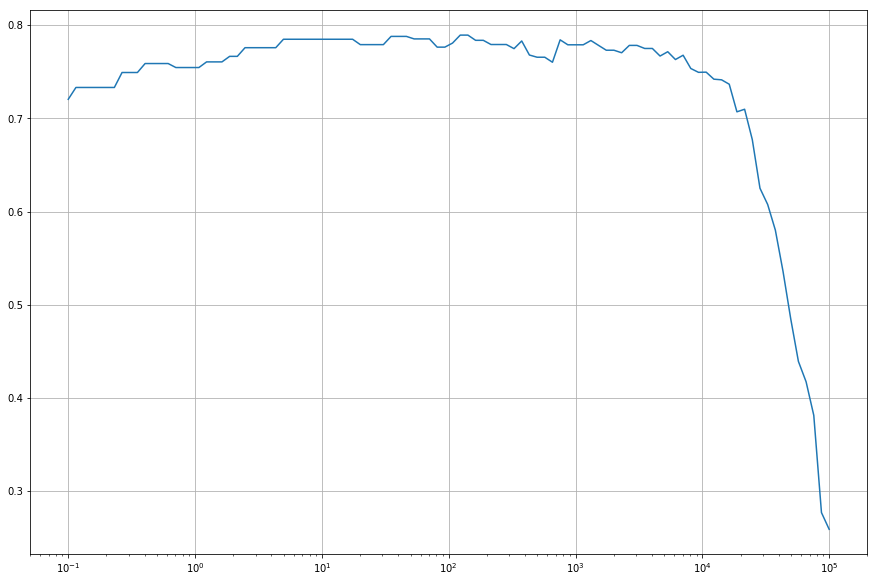

In [207]:
mus, f_scores = analyze_mu(test_set_smth, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

fig = plt.figure(figsize=[15,10])
plt.semilogx()
plt.plot(mus, f_scores)
plt.grid()
plt.show()

## Mu  estimation

In [24]:
def loo_smoothing(segm_cnt_dict, corpus_prb_dict, mu):
    result_dct = dict()
    #d = len(segm_dict.keys())
    d = sumDictValues(segm_cnt_dict) - 1
    for key in corpus_prb_dict.keys():
        if key in segm_cnt_dict:
            result_dct[key] = segm_cnt_dict[key]*np.log2((segm_cnt_dict[key] - 1 + mu*corpus_prb_dict[key])/(d-1+mu))
        else:
            result_dct[key] = 0
    return result_dct

In [25]:
def profit_function(u_param, doc_cnt_dcts, corp_prb_dct):
    profit = 0
    for dct in doc_cnt_dcts:
#         print(len(loo_smoothing(dct, corp_prb_dct, u_param)))
        profit += sumDictValues(loo_smoothing(dct, corp_prb_dct, u_param))
    return -profit
    

print(profit_function(55000, [sum_dct, edctn_dct, xprnc_dct], whole_dict_prb))

pfvec = np.vectorize(profit_function, excluded=[1,2])

171916.903012


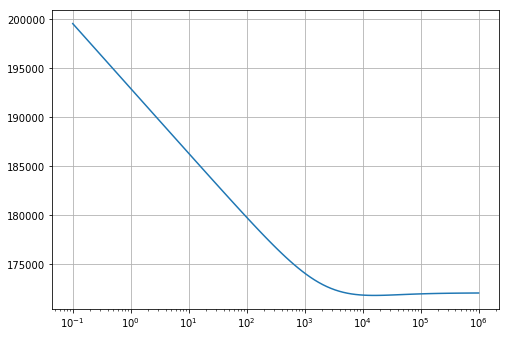

In [208]:
mu_ary = np.geomspace(.1, 1000000, num=100)
prf_ary = pfvec(mu_ary, [sum_dct, edctn_dct, xprnc_dct], whole_dict_prb)
fig, ax = plt.subplots(figsize=[8,5.5])
plt.semilogx()
plt.plot(mu_ary, prf_ary)
plt.grid()
plt.show()

In [27]:
init_mu = np.zeros(1)+1e-30
mu_cnvg = optimize.minimize(profit_function, init_mu, args=([sum_dct, edctn_dct, xprnc_dct], whole_dict_prb), method='Nelder-Mead', options={'maxiter':5000}, tol=1e-30)

In [28]:
print(mu_cnvg)

 final_simplex: (array([[ 15872.44329757],
       [ 15872.44329757]]), array([ 171816.36760442,  171816.36760442]))
           fun: 171816.36760441668
       message: 'Optimization terminated successfully.'
          nfev: 372
           nit: 174
        status: 0
       success: True
             x: array([ 15872.44329757])


In [29]:
#leave-one-out
test_algorithm_w_smoothing(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict, dirichlet_smoothing, mu_cnvg.x)

0.73664896305549654

In [30]:
#empirical evaluation
test_algorithm_w_smoothing(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict, dirichlet_smoothing, 10723)

0.74959276727521651

## Lambda  estimation

In [117]:
def profit_func_lambda(lmbd_param, pi_param_ary, doc_prb_dcs, corp_prb_dct):
    result = .0
    key_limit = 100
    for i in range(pi_param_ary.size):
        sub_rslt = 1.0
        j = 0
        for key in corp_prb_dct.keys():
#             print(key)
            j+=1
            if key in doc_prb_dcs:
#                 print(doc_prb_dcs[i][key])
                sub_rslt *= (1-lmbd_param)*doc_prb_dcs[i][key] + lmbd_param*corp_prb_dct[key]
            else:
                sub_rslt *= lmbd_param * corp_prb_dct[key]
            if j>key_limit:
                break
#         print('pi={}'.format(pi_param_ary[i]))
        result += pi_param_ary[i] * sub_rslt
    return result

init_pi = np.ones(3)

In [118]:
print(profit_func_lambda(.5, init_pi, [sum_prb, edctn_prb, xprnc_prb], whole_dict_prb))

0.0


In [81]:
sum_prb['summari']

0.010533469249065579

In [84]:
(1-.5)*sum_prb['summari'] + .5*whole_dict_prb['summari']

0.006177015104705743

# Testing on Other folder

In [209]:
# Extract test set from 'other' folder
file_number_in_folder=6
extract.extract_other_pdfs(file_number_in_folder)

In [210]:
# Test data generation
other_test_content = open('test_other.txt', 'r').read()

In [211]:
# Head of selected CV
other_test_content[:100]

'Stefan Petranek  78 Vermont Street Rochester, NY 14609     spetrane@yahoo\n.com     (585) 256 0296   '

In [212]:
test_set_other = construct_marked_set([other_test_content])

In [225]:
test_set_other_KL = construct_marked_set_KL([other_test_content])

In [258]:
dummy_f1, result_other_set = test_algorithm(test_set_other, [sum_dct, edctn_dct, xprnc_dct], whole_dict, smoothing=True, smoothing_method=dirichlet_smoothing, smoothing_param=123)

In [259]:
dummy_f1, result_other_set_KL = test_algorithm_w_KL(test_set_other_KL, [sum_dct, edctn_dct, xprnc_dct], whole_dict, smoothing=True, smoothing_method=dirichlet_smoothing, smoothing_param=123)

In [255]:
def print_recognition_results(test_set):
    category=''
    for line in test_set:
        if line[2] == '1':
            category = 'Summary'
        elif line[2] == '2':
            category = 'Education'
        else:
            category = 'Experience'
        print(line[0][:50] + '...\t\t' + category)
        

def print_recognition_results_KL(test_set, ts_KL):
    category=''
    i=0
    for line in test_set:
        if line[2] == 1:
            category = 'Summary'
        elif line[2] == 2:
            category = 'Education'
        else:
            category = 'Experience'
        print(ts_KL[i][0][:50] + '...\t\t' + category)
        i += 1


### 'Other' CVs classification with K

In [260]:
print_recognition_results_KL(result_other_set_KL, test_set_other)

Stefan Petranek  78 Vermont Street Rochester  NY 1...		Experience
  EDUCATION   Rochester Institute of Technology   ...		Education
Areas of interest   photography  video  and instal...		Experience
  Bowdoin College   Brunswick  ME  A B  Biology  m...		Education
 with  Honors  in Biology  Phi Beta Kappa Society ...		Education
Study abroad coursework at Universidad Austral de ...		Education
 Tweaking the Periodic Table  Reflections on Scien...		Education
  Artist Talk    Panel discussion for  Naturally  ...		Experience
  Draft Magazine   Page 26  Issue 3  Independent S...		Education
  Contributing photographer  Published by  Rochest...		Education
  SPE Mid Atlantic Regional Conference  George Mad...		Education
  Graduate Student Scholarship   Society of Photog...		Education
  North American Nature Photography Association In...		Experience
  Bowdoin College  2004   SELECTED EXHIBITIONS    ...		Experience
  Video work  Spring  selected by curator Brenda L...		Experience
  RIT Faculty Show 

In [261]:
print_recognition_results(result_other_set)

Stefan Petranek  78 Vermont Street Rochester  NY 1...		Education
  EDUCATION   Rochester Institute of Technology   ...		Education
Areas of interest   photography  video  and instal...		Experience
  Bowdoin College   Brunswick  ME  A B  Biology  m...		Education
 with  Honors  in Biology  Phi Beta Kappa Society ...		Education
Study abroad coursework at Universidad Austral de ...		Education
 Tweaking the Periodic Table  Reflections on Scien...		Education
  Artist Talk    Panel discussion for  Naturally  ...		Experience
  Draft Magazine   Page 26  Issue 3  Independent S...		Education
  Contributing photographer  Published by  Rochest...		Education
  SPE Mid Atlantic Regional Conference  George Mad...		Education
  Graduate Student Scholarship   Society of Photog...		Education
  North American Nature Photography Association In...		Experience
  Bowdoin College  2004   SELECTED EXHIBITIONS    ...		Education
  Video work  Spring  selected by curator Brenda L...		Experience
  RIT Faculty Show   